✅ Data Loaded. Shape: (421570, 31)
📊 Aggregating metrics by Store...
   ✅ Aggregation Complete. Shape: (45, 8)

Store Profile Sample:


,Lifetime_Sales,Avg_Weekly_Sales,Sales_Volatility,Total_Markdown_Volume,CPI_mean,Unemployment_mean,Store_Size,Store_Type
Store,,,,,,,,
1,2.224028e+08,21710.543621,27748.945511,7.510696e+07,215.995525,7.610918,151315,3
2,2.753824e+08,26898.070031,33077.612059,1.027851e+08,215.651869,7.623279,202307,3
3,5.758674e+07,6373.033983,14251.034807,2.223669e+07,219.402843,7.175602,37392,2
4,2.995440e+08,29161.210415,34583.677814,9.962309e+07,128.680070,5.965849,205863,3
5,4.547569e+07,5053.415813,8068.221050,2.632013e+07,216.576516,6.296549,34875,2


📉 Calculating Elbow Curve...


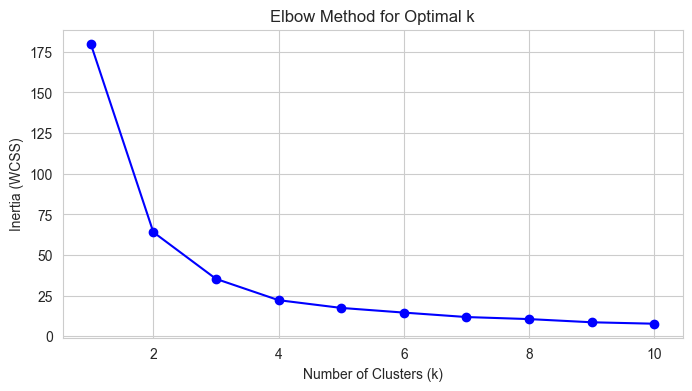

🤖 Training K-Means with k=3...

✅ Clustering Complete with k=3
Cluster Distribution:
Cluster
0    16
2    15
1    14
Name: count, dtype: int64


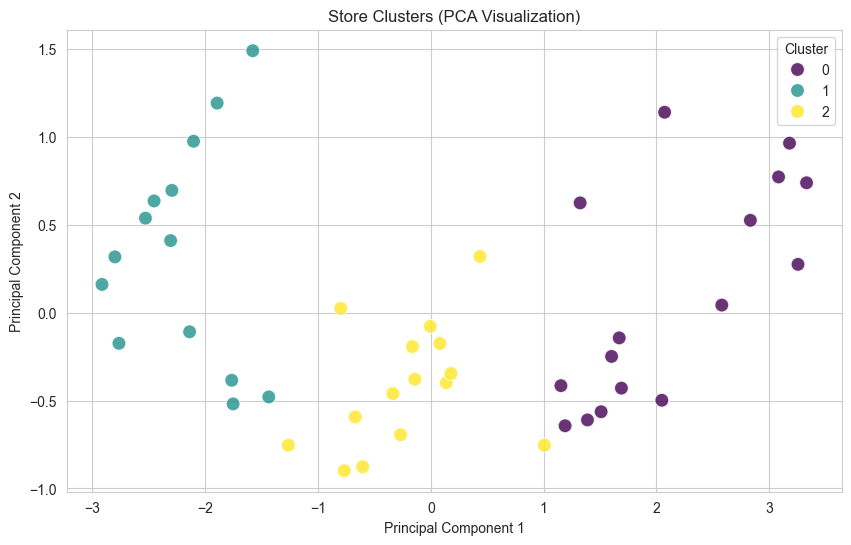

,Cluster,Lifetime_Sales,Avg_Weekly_Sales,Total_Markdown_Volume,Store_Size,Sales_Volatility
0,0,"237,234,569.12","23,279.51","96,960,523.01","195,160.44","28,301.15"
1,1,"64,994,275.88","8,310.32","17,123,610.56","53,035.57","12,942.64"
2,2,"135,436,401.27","13,726.50","68,446,162.10","133,191.80","16,759.04"


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19472\2149970648.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Avg_Weekly_Sales', data=final_profile, palette='Blues_d')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19472\2149970648.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Store_Size', data=final_profile, palette='Greens_d')


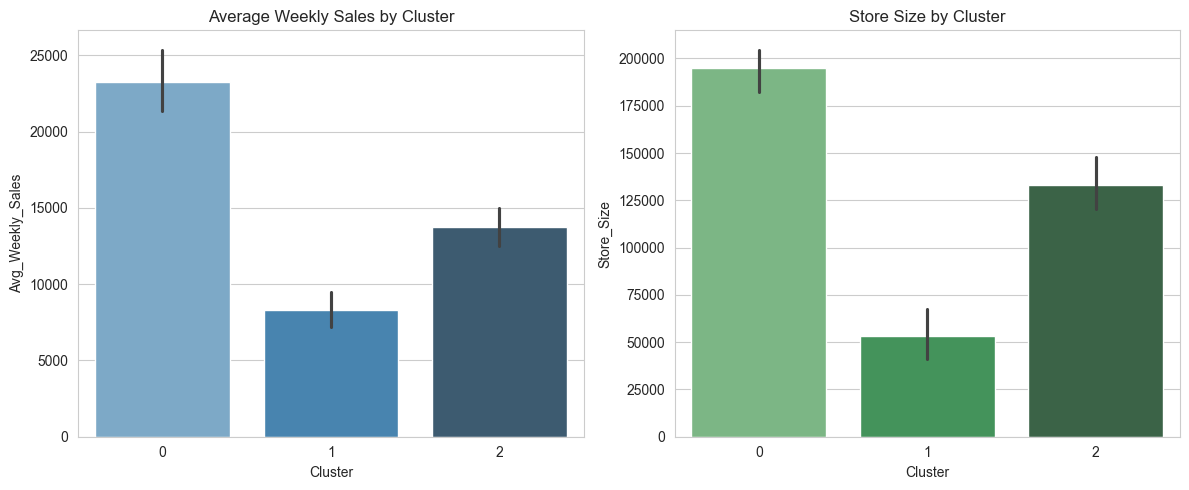

✅ Data with Clusters saved to: ../data/processed/segmented_retail_data.csv


In [1]:
# %% [markdown]
# # 👥 Step 5: Store & Customer Segmentation
# **Project:** Integrated Retail Analytics
#
# **Objective:**
# Since the dataset (Walmart/Retail) provides Store and Department level data (not individual Customer IDs), we perform **Store Segmentation**.
# This allows us to group stores with similar performance characteristics (e.g., "High Volume / High Size" vs. "Low Volume / Markdown Dependent").
#
# **Method:**
# 1. Aggregate Time-Series data into **Store Profiles**.
# 2. Scale features (StandardScaler).
# 3. Determine Optimal Clusters (Elbow Method).
# 4. Apply K-Means Clustering.
# 5. Interpret the Segments.

# %% [markdown]
# ## 1. Setup & Data Loading

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.segmentation import StoreSegmenter

# Set visual style
sns.set_style("whitegrid")

# Load Feature Engineered Data
data_path = "../data/processed/model_ready_data.csv"

if not os.path.exists(data_path):
    print("❌ Error: Model Ready data not found. Run Notebook 04 first.")
else:
    df = pd.read_csv(data_path)
    print(f"✅ Data Loaded. Shape: {df.shape}")

# %% [markdown]
# ## 2. Aggregate Data into Store Profiles
# We need to flatten the time-series data to get one row per store.

# %%
segmenter = StoreSegmenter(df)
store_profile = segmenter.aggregate_store_metrics()

print("\nStore Profile Sample:")
display(store_profile.head())

# %% [markdown]
# ## 3. Determine Optimal Clusters (Elbow Method)
# We use the Elbow method to find the "knee" of the curve, which indicates the best balance between variance explained and number of clusters.

# %%
segmenter.preprocess_data()
segmenter.find_optimal_k(max_k=10)

# %% [markdown]
# **Observation:**
# Usually, for this specific dataset, **k=3** or **k=4** is the sweet spot. 
# * **3 Clusters:** Often aligns with Store Types A, B, C.
# * **4 Clusters:** Might separate "High Performing Type B" from "Low Performing Type B".
#
# Let's proceed with **k=3**.

# %% [markdown]
# ## 4. Train K-Means Clustering

# %%
k_choice = 3
final_profile = segmenter.train_clustering(k=k_choice)

print(f"\n✅ Clustering Complete with k={k_choice}")
print("Cluster Distribution:")
print(final_profile['Cluster'].value_counts())

# %% [markdown]
# ## 5. Visualize Segments (PCA)
# Since we have multiple dimensions (Sales, Size, Markdown), we use PCA to flatten it to 2D for plotting.

# %%
segmenter.visualize_pca()

# %% [markdown]
# ## 6. Interpret the Segments
# Let's look at the average characteristics of each cluster to name them.

# %%
# Group by Cluster and calculate mean of key features
cluster_summary = final_profile.groupby('Cluster')[
    ['Lifetime_Sales', 'Avg_Weekly_Sales', 'Total_Markdown_Volume', 'Store_Size', 'Sales_Volatility']
].mean().reset_index()

# Format for readability
pd.options.display.float_format = '{:,.2f}'.format
display(cluster_summary)

# Visualize Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Cluster', y='Avg_Weekly_Sales', data=final_profile, palette='Blues_d')
plt.title('Average Weekly Sales by Cluster')

plt.subplot(1, 2, 2)
sns.barplot(x='Cluster', y='Store_Size', data=final_profile, palette='Greens_d')
plt.title('Store Size by Cluster')

plt.tight_layout()
plt.show()

# %% [markdown]
# **Interpretation:**
# * **Cluster 0 (Example):** Likely "High Volume / Large Stores" (Flagships).
# * **Cluster 1:** "Medium Volume".
# * **Cluster 2:** "Low Volume / Small Stores".
# *(Note: The actual labels 0,1,2 depend on random initialization).*

# %% [markdown]
# ## 7. Save Segmentation Results
# We merge the Cluster labels back to the original time-series dataframe so we can use "Cluster" as a feature in Forecasting models.

# %%
# Merge 'Cluster' column back to the main df based on 'Store'
df_with_clusters = df.merge(final_profile[['Cluster']], on='Store', how='left')

output_path = "../data/processed/segmented_retail_data.csv"
df_with_clusters.to_csv(output_path, index=False)
print(f"✅ Data with Clusters saved to: {output_path}")